In [1]:
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader,TensorDataset
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm



DATASET_PATH = "cifar10_images"


In [2]:
transform = transforms.Compose([
    transforms.Resize((96, 96)),   
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])



train_dataset = ImageFolder(root="cifar10_images/train", transform=transform)
test_dataset = ImageFolder(root="cifar10_images/test", transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Text(0.5, 1.0, 'airplane')

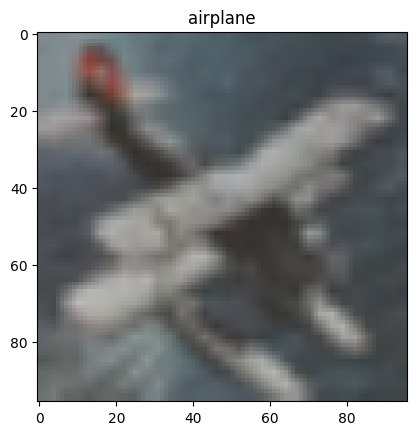

In [ ]:
def save_random_images(dataset, count=5):
    for i in range(count):
        idx = random.randint(0, len(dataset) - 1)
        img, label = dataset[idx]
        img = img.permute(1, 2, 0) * 0.5 + 0.5  
        plt.imshow(img)
        plt.title(dataset.classes[label])
        plt.axis('off')
        plt.savefig(f"sample_{i}.png")


In [ ]:
class PatchEmbedding(nn.Module):
    def __init__(self, patch_size=4, in_channels=3, embed_dim=48):
        super().__init__()
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):  # x: [B, 3, 96, 96]
        x = self.proj(x)   # [B, 48, 24, 24]
        x = x.permute(0, 2, 3, 1)  # [B, 24, 24, 48]
        return x
    


Original image shape: torch.Size([1, 3, 96, 96])
Embedded image shape: torch.Size([1, 24, 24, 48])


In [12]:
class WindowAttention(nn.Module):
    def __init__(self, dim, window_size=6, num_heads=4):
        super().__init__()
        self.dim = dim
        self.window_size = window_size
        self.num_heads = num_heads
        self.head_dim = dim // num_heads
        self.scale = self.head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=True)
        self.proj = nn.Linear(dim, dim)

    def forward(self, x):
        """
        x: [B, H, W, C]
        """
        B, H, W, C = x.shape
        

        # Partition into windows
        x = x.view(B, H // self.window_size, self.window_size,
                   W // self.window_size, self.window_size, C)
        x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, self.window_size * self.window_size, C)
        # Now: [num_windows*B, 36, C]

        # Compute QKV
        qkv = self.qkv(x)  # → [num_windows*B, 36, 3*C]
        qkv = qkv.view(qkv.shape[0], qkv.shape[1], 3, self.num_heads, self.head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)  # → [3, num_windows*B, num_heads, 36, head_dim]
        q, k, v = qkv[0], qkv[1], qkv[2]

        # Scaled dot-product attention
        attn = (q @ k.transpose(-2, -1)) * self.scale  # [B_, heads, 36, 36]
        attn = attn.softmax(dim=-1)

        out = attn @ v  # [B_, heads, 36, head_dim]
        out = out.transpose(1, 2).reshape(x.shape[0], x.shape[1], C)  # [B_, 36, C]

        # Linear projection
        out = self.proj(out)  # [B_, 36, C]

        # Reverse window partitioning
        out = out.view(B, H // self.window_size, W // self.window_size,
                       self.window_size, self.window_size, C)
        out = out.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H, W, C)

        return out

In [15]:
class ShiftedWindowAttention(nn.Module):
    def __init__(self, dim, window_size=6, shift_size=3, num_heads=4):
        super().__init__()
        self.dim = dim
        self.window_size = window_size
        self.shift_size = shift_size
        self.num_heads = num_heads
        self.head_dim = dim // num_heads
        self.scale = self.head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=True)
        self.proj = nn.Linear(dim, dim)

    def create_attention_mask(self, H, W, device):
        """
        Generate the attention mask to block tokens from attending across shifted windows.
        """
        img_mask = torch.zeros((1, H, W, 1), device=device)  # [1, H, W, 1]

        cnt = 0
        for h in (slice(0, -self.window_size), slice(-self.window_size, -self.shift_size), slice(-self.shift_size, None)):
            for w in (slice(0, -self.window_size), slice(-self.window_size, -self.shift_size), slice(-self.shift_size, None)):
                img_mask[:, h, w, :] = cnt
                cnt += 1

        # Partition into windows
        mask_windows = img_mask.unfold(1, self.window_size, self.window_size).unfold(2, self.window_size, self.window_size)
        mask_windows = mask_windows.contiguous().view(-1, self.window_size * self.window_size)

        attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
        attn_mask = attn_mask.masked_fill(attn_mask != 0, float("-inf")).masked_fill(attn_mask == 0, 0.0)

        return attn_mask  # [num_windows, 36, 36]

    def forward(self, x):
        """
        x: [B, H, W, C]
        """
        B, H, W, C = x.shape
        device = x.device

        # Shift the input feature map
        if self.shift_size > 0:
            shifted_x = torch.roll(x, shifts=(-self.shift_size, -self.shift_size), dims=(1, 2))
        else:
            shifted_x = x

        # Partition windows
        x_windows = shifted_x.view(B, H // self.window_size, self.window_size,
                                   W // self.window_size, self.window_size, C)
        x_windows = x_windows.permute(0, 1, 3, 2, 4, 5).reshape(-1, self.window_size * self.window_size, C)

        # QKV
        qkv = self.qkv(x_windows)  # [num_windows*B, 36, 3*C]
        qkv = qkv.view(qkv.shape[0], qkv.shape[1], 3, self.num_heads, self.head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # [B*, heads, 36, head_dim]

        # Attention with masking
        attn = (q @ k.transpose(-2, -1)) * self.scale  # [B*, heads, 36, 36]

        # Apply attention mask
        attn_mask = self.create_attention_mask(H, W, device)
        attn = attn + attn_mask.unsqueeze(0).unsqueeze(1)  # broadcast over batch and heads

        attn = attn.softmax(dim=-1)
        out = attn @ v  # [B*, heads, 36, head_dim]

        out = out.transpose(1, 2).reshape(x_windows.shape[0], x_windows.shape[1], C)
        out = self.proj(out)  # [B*, 36, C]

        # Reverse windows
        out = out.view(B, H // self.window_size, W // self.window_size,
                       self.window_size, self.window_size, C)
        out = out.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H, W, C)

        # Reverse shift
        if self.shift_size > 0:
            out = torch.roll(out, shifts=(self.shift_size, self.shift_size), dims=(1, 2))

        return out
    


In [16]:
class SwinTransformerBlock(nn.Module):
    def __init__(self, dim, num_heads, window_size=6, shift_size=0):
        super().__init__()
        self.window_size = window_size
        self.shift_size = shift_size
        self.norm1 = nn.LayerNorm(dim)
        self.attn = WindowAttention(dim, num_heads = 6, window_size = 4)

        self.norm2 = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, dim * 4),
            nn.GELU(),
            nn.Linear(dim * 4, dim)
        )

    def forward(self, x):
        B, H, W, C = x.shape

        # -------------------------------
        # 1. LayerNorm -> W-MSA/SW-MSA -> Residual
        shortcut = x
        x = self.norm1(x)
        x = self.attn(x)  # W-MSA or SW-MSA depending on shift
        x = shortcut + x

        # -------------------------------
        # 2. LayerNorm -> FFN -> Residual
        shortcut2 = x
        x = self.norm2(x)
        x = self.mlp(x)
        x = shortcut2 + x

        return x

In [14]:
class PatchMerging(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.reduction = nn.Linear(4 * input_dim, 2 * input_dim, bias=False)
        self.norm = nn.LayerNorm(4 * input_dim)

    def forward(self, x):
        B, H, W, C = x.shape
        assert H % 2 == 0 and W % 2 == 0, "Height and Width must be divisible by 2"

        # Step 1: reshape 2x2 patches into one
        x0 = x[:, 0::2, 0::2, :]  # top-left
        x1 = x[:, 0::2, 1::2, :]  # top-right
        x2 = x[:, 1::2, 0::2, :]  # bottom-left
        x3 = x[:, 1::2, 1::2, :]  # bottom-right

        # Step 2: concatenate along the channel dimension
        x_merged = torch.cat([x0, x1, x2, x3], dim=-1)  # Shape: [B, H/2, W/2, 4C]

        # Step 3: normalization and linear projection to reduce dim
        x_merged = self.norm(x_merged)
        x_merged = self.reduction(x_merged)  # Shape: [B, H/2, W/2, 2C]

        return x_merged
    


In [13]:
class ClassificationHead(nn.Module):
    def __init__(self, embed_dim=192, num_classes=10):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)  # pools HxW to 1x1
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        # x shape: [B, H, W, C] → convert to [B, C, H, W]
        x = x.permute(0, 3, 1, 2)
        x = self.avg_pool(x)           # [B, C, 1, 1]
        x = x.view(x.size(0), -1)      # [B, C]
        return self.fc(x)              # [B, num_classes]

In [17]:
class SimpleSwin(nn.Module):
    def __init__(self, 
                 input_dim=48, 
                 num_classes=10, 
                 window_size=6):
        super().__init__()

        # Stage 1: Input [B, 24, 24, 48]
        self.stage1 = nn.Sequential(
            SwinTransformerBlock(dim=48, num_heads=4, window_size=window_size, shift_size=0),
            SwinTransformerBlock(dim=48, num_heads=4, window_size=window_size, shift_size=3),
        )
        self.merge1 = PatchMerging(input_dim=48)

        # Stage 2: Input [B, 12, 12, 96]
        self.stage2 = nn.Sequential(
            SwinTransformerBlock(dim=96, num_heads=4, window_size=window_size, shift_size=0),
            SwinTransformerBlock(dim=96, num_heads=4, window_size=window_size, shift_size=3),
        )
        self.merge2 = PatchMerging(input_dim=96)

        # Stage 3: Input [B, 6, 6, 192]
        self.stage3 = nn.Sequential(
            SwinTransformerBlock(dim=192, num_heads=6, window_size=window_size, shift_size=0),
            SwinTransformerBlock(dim=192, num_heads=6, window_size=window_size, shift_size=3),
            SwinTransformerBlock(dim=192, num_heads=6, window_size=window_size, shift_size=0),
            SwinTransformerBlock(dim=192, num_heads=6, window_size=window_size, shift_size=3),
        )

        # Final classification head
        self.norm = nn.LayerNorm(192)
        self.head = ClassificationHead(embed_dim=192, num_classes=num_classes)

    def forward(self, x):
        # x: [B, 24, 24, 48]

        x = self.stage1(x)     # → [B, 24, 24, 48]
        x = self.merge1(x)     # → [B, 12, 12, 96]

        x = self.stage2(x)     # → [B, 12, 12, 96]
        x = self.merge2(x)     # → [B, 6, 6, 192]

        x = self.stage3(x)     # → [B, 6, 6, 192]
        x = self.norm(x)       # LayerNorm over final features

        out = self.head(x)     # → [B, num_classes]
        return out
    




In [18]:
# Instantiate everything
device = torch.device("cpu")
patch_embed = PatchEmbedding().to(device)
model = SimpleSwin().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3)


In [20]:
# Training loop
def train(model, loader, optimizer, criterion, epoch):
    model.train()
    total_loss = 0

    for imgs, labels in tqdm(loader, desc=f"Epoch {epoch}"):
        imgs, labels = imgs.to(device), labels.to(device)
        patches = patch_embed(imgs)  # [B, 24, 24, 48]

        outputs = model(patches)     # [B, 10]
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(loader)
    print(f"Train Loss: {avg_loss:.4f}")


In [21]:
def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            patches = patch_embed(imgs)

            outputs = model(patches)
            _, preds = torch.max(outputs, dim=1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

    acc = 100 * correct / total
    print(f"Test Accuracy: {acc:.2f}%")


In [22]:
# Train for a few epochs
for epoch in range(1, 6):
    train(model, train_loader, optimizer, criterion, epoch)
    evaluate(model, test_loader)
     # Save model after each epoch (optional)
    torch.save(model.state_dict(), f"simple_swin_epoch{epoch}.pth")

Epoch 1:   0%|          | 0/782 [00:00<?, ?it/s]


RuntimeError: shape '[64, 1, 4, 1, 4, 192]' is invalid for input of size 442368